## Model Load

In [1]:
from utils import set_root

from loguru import logger

import numpy as np
import torch

from tqdm import tqdm


from pytorch_lightning import seed_everything
import importlib

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import signal
import pandas as pd

seed_everything(42)
set_root()

Seed set to 42


Current working directory: /home/manni/physioex


In [2]:
%ls

LICENSE*                             mkdocs.yml*
README.md*                           models/
__pycache__/                         multi-source-domain.yaml*
docs/                                my_experiment.yaml*
embeddings_mass_ssh_conv3d.npy       physioex/
embeddings_mass_ssh_seqsleepnet.npy  physioex.egg-info/
examples/                            requirements.txt*
input_to_check.pt                    scheduler.txt*
label_to_check.pt                    setup.py*
labels_mass_ssh_conv3d.npy           teacher_student.py*
labels_mass_ssh_seqsleepnet.npy      teacherstudent.yaml*
lightning_logs/                      temp/
main.py*


In [3]:
#from physioex.data import TimeDistributedModule, SleepEDF, Shhs, SleepMerged
from physioex.data.datamodule import PhysioExDataModule
from physioex.data import get_datasets

from physioex.train.networks import config as networks
from physioex.train.networks.utils.loss import config as losses

from physioex.models import load_pretrained_model

from physioex.train.networks.utils.target_transform import get_mid_label

Seed set to 42
Seed set to 42


In [4]:
# importing
import numpy as np
from loguru import logger
import os
import math

from physioex.train.networks import config

from tqdm import tqdm
import torch
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

from loguru import logger

logger.remove()

In [5]:
import seaborn as sns
max = 3
min = -3

def plotTheSpectrogram(spectrogram_tensor, max, min):
    spectrogram_array = spectrogram_tensor.permute(1, 0).numpy()
    
    plt.figure(figsize=(5, 5))
    #plt.imshow(spectrogram_array, aspect='auto', origin='lower', cmap='viridis',vmin=-3, vmax=4)
    #plt.imshow(spectrogram_array, aspect='auto', origin='lower', cmap='coolwarm')
    sns.heatmap(spectrogram_array, cmap='coolwarm', cbar=True, vmax=max, vmin=min)
            
    #plt.colorbar(format='%+2.0f')
    plt.title('Spectrogram')
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

def plotSpectrogram(ax, spectrogram_tensor, title, max, min):
    spectrogram_array = spectrogram_tensor.permute(1, 0).numpy()
    
    sns.heatmap(spectrogram_array, cmap='coolwarm', cbar=True, vmax=max, vmin=min, ax=ax,)

    ax.set_title(title)
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency')
    ax.invert_yaxis()

def plotSpectrograms(spectrograms, titles, max, min):
    n = len(spectrograms)
    fig, axes = plt.subplots(math.ceil(n/2), 2, figsize=(10, 5*math.ceil(n/2)))
    # Esegui il plot per ogni spettrogramma
    for i, (ax, spectrogram) in enumerate(zip(axes.flatten(), spectrograms)):
        plotSpectrogram(ax, spectrogram, titles[i], max=max, min=min)

    plt.tight_layout()
    plt.show()

def plotSpectrograms12(spectrograms, titles, max, min):
    fig, axes = plt.subplots(4, 3, figsize=(15, 20))
    # Esegui il plot per ogni spettrogramma
    for i, (ax, spectrogram) in enumerate(zip(axes.flatten(), spectrograms)):
        plotSpectrogram(ax, spectrogram, titles[i], max=max, min=min)

    plt.tight_layout()
    plt.show()

def plotSpectrograms15(spectrograms, titles, max, min):
    fig, axes = plt.subplots(5, 3, figsize=(15, 25))
    # Esegui il plot per ogni spettrogramma
    for i, (ax, spectrogram) in enumerate(zip(axes.flatten(), spectrograms)):
        plotSpectrogram(ax, spectrogram, titles[i], max=max, min=min)

    plt.tight_layout()
    plt.show()

def plotSpectrograms20(spectrograms, titles, max, min):
    fig, axes = plt.subplots(7, 3, figsize=(15, 35))
    # Esegui il plot per ogni spettrogramma
    for i, (ax, spectrogram) in enumerate(zip(axes.flatten(), spectrograms)):
        plotSpectrogram(ax, spectrogram, titles[i], max=max, min=min)

    plt.tight_layout()
    plt.show()

In [6]:
def get_single_file_path(directory):
    # Lista di tutti i file nella cartella
    files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    
    # Controlla che ci sia un solo file nella cartella
    if len(files) == 1:
        return os.path.join(directory, files[0])
    else:
        raise ValueError("La cartella non contiene esattamente un file.")

In [7]:
# model parameters
model_name1 = "protoae_seqsleepnet"
model_name2 = "protoae_seqsleepnet"
model_name3 = "protoae_seqsleepnet"
model_name4 = "protoae_seqsleepnet"
model_name5 = "protoae_seqsleepnet"

# load dataset and model
model = networks[model_name1]
# model2 = networks[model_name2]
# model3 = networks[model_name3]
# model4 = networks[model_name4]


In [8]:
checkpoint1 = get_single_file_path('models/protoae_seqsleepnet/proto15_shhs3611')
# checkpoint1 = get_single_file_path('models/protoae_seqsleepnet/proto_mass3611')
# checkpoint2 = get_single_file_path('models/protoae_seqsleepnet/proto15_mass3611')
# checkpoint3 = get_single_file_path('models/protoae_seqsleepnet/proto15_shhs3611')
# checkpoint4 = get_single_file_path('models/protoae_seqsleepnet/proto10_shhs36110.5_newr3')

In [9]:
# dataset
picks = ["EEG"]
fold = 0
sequence_length = 3

# dataloader
batch_size = 128

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dict1 = {"batch_size": 128}

#results_dir = f"results/{model_name}/"

In [10]:
dataset = PhysioExDataModule(
    datasets= ["shhs"],
    versions = None,
    folds = -1,
    batch_size=batch_size,
    preprocessing=model["input_transform"],
    selected_channels=picks,
    sequence_length = sequence_length,
    target_transform=model["target_transform"],
    data_folder = "/home/guidogl/physioex-data/"
)

['shhs'] None
/home/guidogl/physioex-data/


In [11]:
dict1 = {"batch_size": 128, "n_prototypes": 15}

model1 = load_pretrained_model(
    name=model_name1,
    in_channels=len(picks),
    sequence_length=sequence_length,
    softmax=False,
    loss = "mse",
    ckpt_path=checkpoint1,
    extra_params = dict1
).eval()


In [12]:
dict1 = {"batch_size": 128, "n_prototypes": 15}

model2 = load_pretrained_model(
    name=model_name2,
    in_channels=len(picks),
    sequence_length=sequence_length,
    softmax=False,
    loss = "mse",
    ckpt_path=checkpoint2,
    extra_params = dict1
).eval()

NameError: name 'checkpoint2' is not defined

In [ ]:
dict1 = {"batch_size": 128, "n_prototypes": 15}

model3 = load_pretrained_model(
    name=model_name3,
    in_channels=len(picks),
    sequence_length=sequence_length,
    softmax=False,
    loss = "mse",
    ckpt_path=checkpoint3,
    extra_params = dict1
).eval()

In [14]:
dict1 = {"batch_size": 128, "n_prototypes": 10}

model4 = load_pretrained_model(
    name=model_name4,
    in_channels=len(picks),
    sequence_length=sequence_length,
    softmax=False,
    loss = "mse",
    ckpt_path=checkpoint4,
    extra_params = dict1
).eval()

In [15]:
# class MidModel(torch.nn.Module):
#     def __init__(self, model):
#         super(MidModel, self).__init__()
#         self.model = model

#     def forward(self, x):
#         return self.model(x)[:, int((x.shape[1] - 1) / 2)]


# model1 = MidModel(model1)
# model2 = MidModel(model2)
# model3 = MidModel(model3)

  0%|          | 0/12780 [00:00<?, ?it/s]

inputs: torch.Size([128, 3, 1, 29, 129])
labels: torch.Size([128, 3])
labels size: torch.Size([3])
N2
reconstruction_1 torch.Size([29, 129])
embeddings_1 torch.Size([32])
classification_1 torch.Size([5])
torch.Size([29, 129])


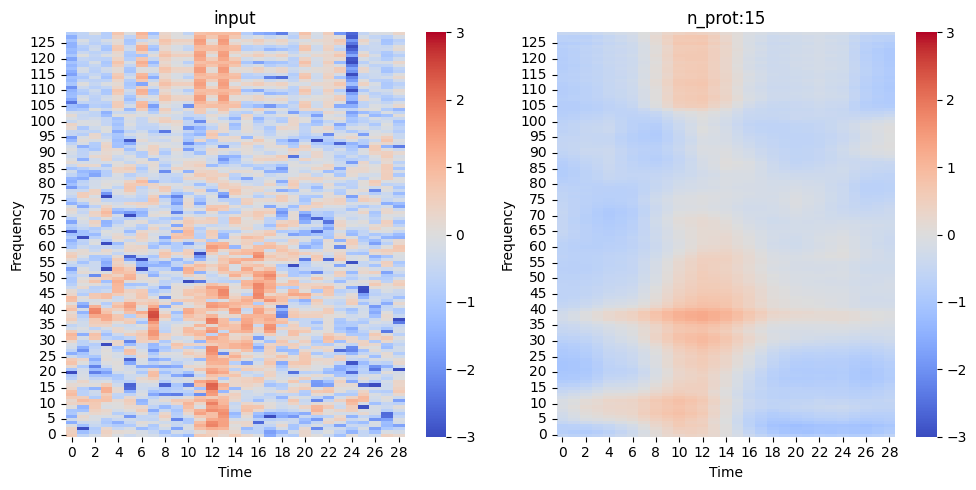

  0%|          | 0/12780 [00:59<?, ?it/s]


In [38]:
# compute the metrics on the test set
sleep_stages = ["Awake", "N1", "N2", "N3", "REM"]
dataloder = dataset.test_dataloader()

central_epoch = int((sequence_length-1) / 2)

with torch.no_grad():
    # Aggiungi tqdm per mostrare il progresso
    for i, (inputs, labels) in tqdm(enumerate(dataloder), total=len(dataloder)):
        print("inputs:", inputs.size())
        print("labels:", labels.size())
        indici = np.argwhere(labels.squeeze() == 1) # 0 per la classe awake, 1 per la classe N1 ecc
        indices_list = indici.tolist()[0]
        if(len(indices_list) > 2):
            #print(indices_list)
            #print(labels.squeeze())
            # Calcola le previsioni del modello
            index = indices_list[0] #prendo il primo indice della lista
            print("labels size:",labels[index].size())
            print(sleep_stages[labels[index][central_epoch].item()])

            input_hat1 = model1(inputs.to(device))
            # input_hat2 = model2(inputs.to(device))
            # input_hat3 = model3(inputs.to(device))
            # input_hat4 = model4(inputs.to(device))

            # input_hat5 = model5(inputs.to(device))
            x = inputs[index][1][0] #0 perchè prendo l'epoca 1 e il secondo 0 è per prendere il primo canale

            reconstruction_1 = input_hat1[0][index][1][0].to("cpu") #reconstruction output
            embeddings_1 = input_hat1[1][index][1] #embedding output
            classification_1 = input_hat1[2][index] #classification output
            
            # reconstruction_2 = input_hat2[0][index][1][0].to("cpu") #reconstruction output
            # embeddings_2 = input_hat2[1][index][1] #embedding output
            # classification_2 = input_hat2[2][index] #classification output
            
            # reconstruction_3 = input_hat3[0][index][1][0].to("cpu") #reconstruction output
            # embeddings_3 = input_hat3[1][index][1] #embedding output
            # classification_3 = input_hat3[2][index] #classification output

            # reconstruction_4 = input_hat4[0][index][1][0].to("cpu") #reconstruction output
            # embeddings_4 = input_hat4[1][index][1] #embedding output
            # classification_4 = input_hat4[2][index] #classification output


            print("reconstruction_1", reconstruction_1.size())
            print("embeddings_1", embeddings_1.size())
            print("classification_1", classification_1.size())
            
            # x_hat2 = input_hat2[index].to("cpu")[1][0] #prendo l'epoca 1 e il secondo 0 è per prendere il primo canale
            # #print("shape x_hat2: ", x_hat2.shape)
            # x_hat3 = input_hat3[index].to("cpu")[1][0] #prendo l'epoca 1 e il secondo 0 è per prendere il primo canale
            # #print("shape x_hat3: ", x_hat3.shape)
            # x_hat4 = input_hat4[index].to("cpu")[1][0] #prendo l'epoca 1 e il secondo 0 è per prendere il primo canale
            # #print("shape x_hat4: ", x_hat4.shape)
            # x_hat5 = input_hat5[index].to("cpu")[1][0] #prendo l'epoca 1 e il secondo 0 è per prendere il primo canale
            # #print("shape x_hat4: ", x_hat4.shape)

            # plotTheSpectrogram(x, max, min)
            # plotTheSpectrogram(x_hat1, max, min)
            # plotTheSpectrogram(x_hat2, max, min)
            # #plotTheSpectrogram(x_hat3, max, min)
            # #plotTheSpectrogram(x_hat4, max, min)
            # plotTheSpectrogram(x_hat5, max, min)
            # plotSpectrograms([x, x_hat1, x_hat2, x_hat3], ["input","ae_seqsleepnet", "ae_seqsleepnet\ng=(1.5,0.5)", "ae_seqsleepnet\ng=(1.95,0.05)"],max, min)
            plotSpectrograms([x, reconstruction_1], ["input", "n_prot:15"], max, min)

            break

# y_true = torch.stack(y_true).numpy()
# y_pred = torch.stack(y_pred).numpy()
# pred_probas = torch.stack(pred_probas).numpy()

## Prototypes

In [12]:
import torch.nn.functional as F

In [13]:
model = model1 #3* cel + 6 *rec + 1 * r1 + 2 *r2

In [14]:
sleep_stages = ["Awake", "N1", "N2", "N3", "REM"]
prototypes1 = model.nn.classifier.prototypes.detach()
L = model.nn.L
print(L)
central_epoch = int((L - 1) / 2)
print(central_epoch, "\n\n")

proto_rec = []
proto_class = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
proto_class_list = []
for proto in prototypes1:
    proto = proto.repeat(3,1).unsqueeze(0) #aggiungo la dimensione dei batch e faccio repeat per simulare le epoche
    proto_rec.append(model.nn.decode(proto)[0][central_epoch][0].to("cpu").detach())
    proto_class.update({int(model.nn.classifier(proto).argmax().to("cpu").detach()):proto_class[int(model.nn.classifier(proto).argmax().to("cpu").detach())]+1})
    proto_class_list.append(sleep_stages[int(model.nn.classifier(proto).argmax().to("cpu").detach())] + " - " + "{:.2f}".format(F.softmax(model.nn.classifier(proto), dim=1)[0][int(model.nn.classifier(proto).argmax().to("cpu").detach())].item()))
    print(int(model.nn.classifier(proto).argmax().to("cpu").detach()))
    print(F.softmax(model.nn.classifier(proto), dim=1))
    print(model.nn.classifier(proto))
    
print(proto_class)
print(proto_class_list)

3
1 


0
tensor([[9.9960e-01, 2.8333e-04, 2.9451e-07, 8.9898e-05, 2.3344e-05]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([[ 8.1972,  0.0287, -6.8404, -1.1192, -2.4676]], device='cuda:0',
       grad_fn=<MmBackward0>)
2
tensor([[1.8269e-04, 9.4796e-05, 9.9878e-01, 7.6735e-04, 1.7861e-04]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([[-2.6977, -3.3537,  5.9088, -1.2625, -2.7203]], device='cuda:0',
       grad_fn=<MmBackward0>)
3
tensor([[2.3460e-04, 2.1855e-08, 4.2429e-04, 9.9919e-01, 1.5402e-04]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([[-0.6776, -9.9588, -0.0851,  7.6792, -1.0984]], device='cuda:0',
       grad_fn=<MmBackward0>)
0
tensor([[9.9357e-01, 6.1829e-03, 7.7640e-06, 1.2721e-04, 1.0879e-04]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([[ 6.5818,  1.5023, -5.1777, -2.3814, -2.5378]], device='cuda:0',
       grad_fn=<MmBackward0>)
1
tensor([[3.0683e-02, 9.2247e-01, 2.6014e-02, 6.9593e-04, 2.0137e-02]],
       d

In [15]:
mean_conf = 0
for conf in proto_class_list:
    mean_conf = mean_conf + float(conf.split("- ")[1])
mean_conf = mean_conf / len(proto_class_list)
print(mean_conf)

0.9920000000000001


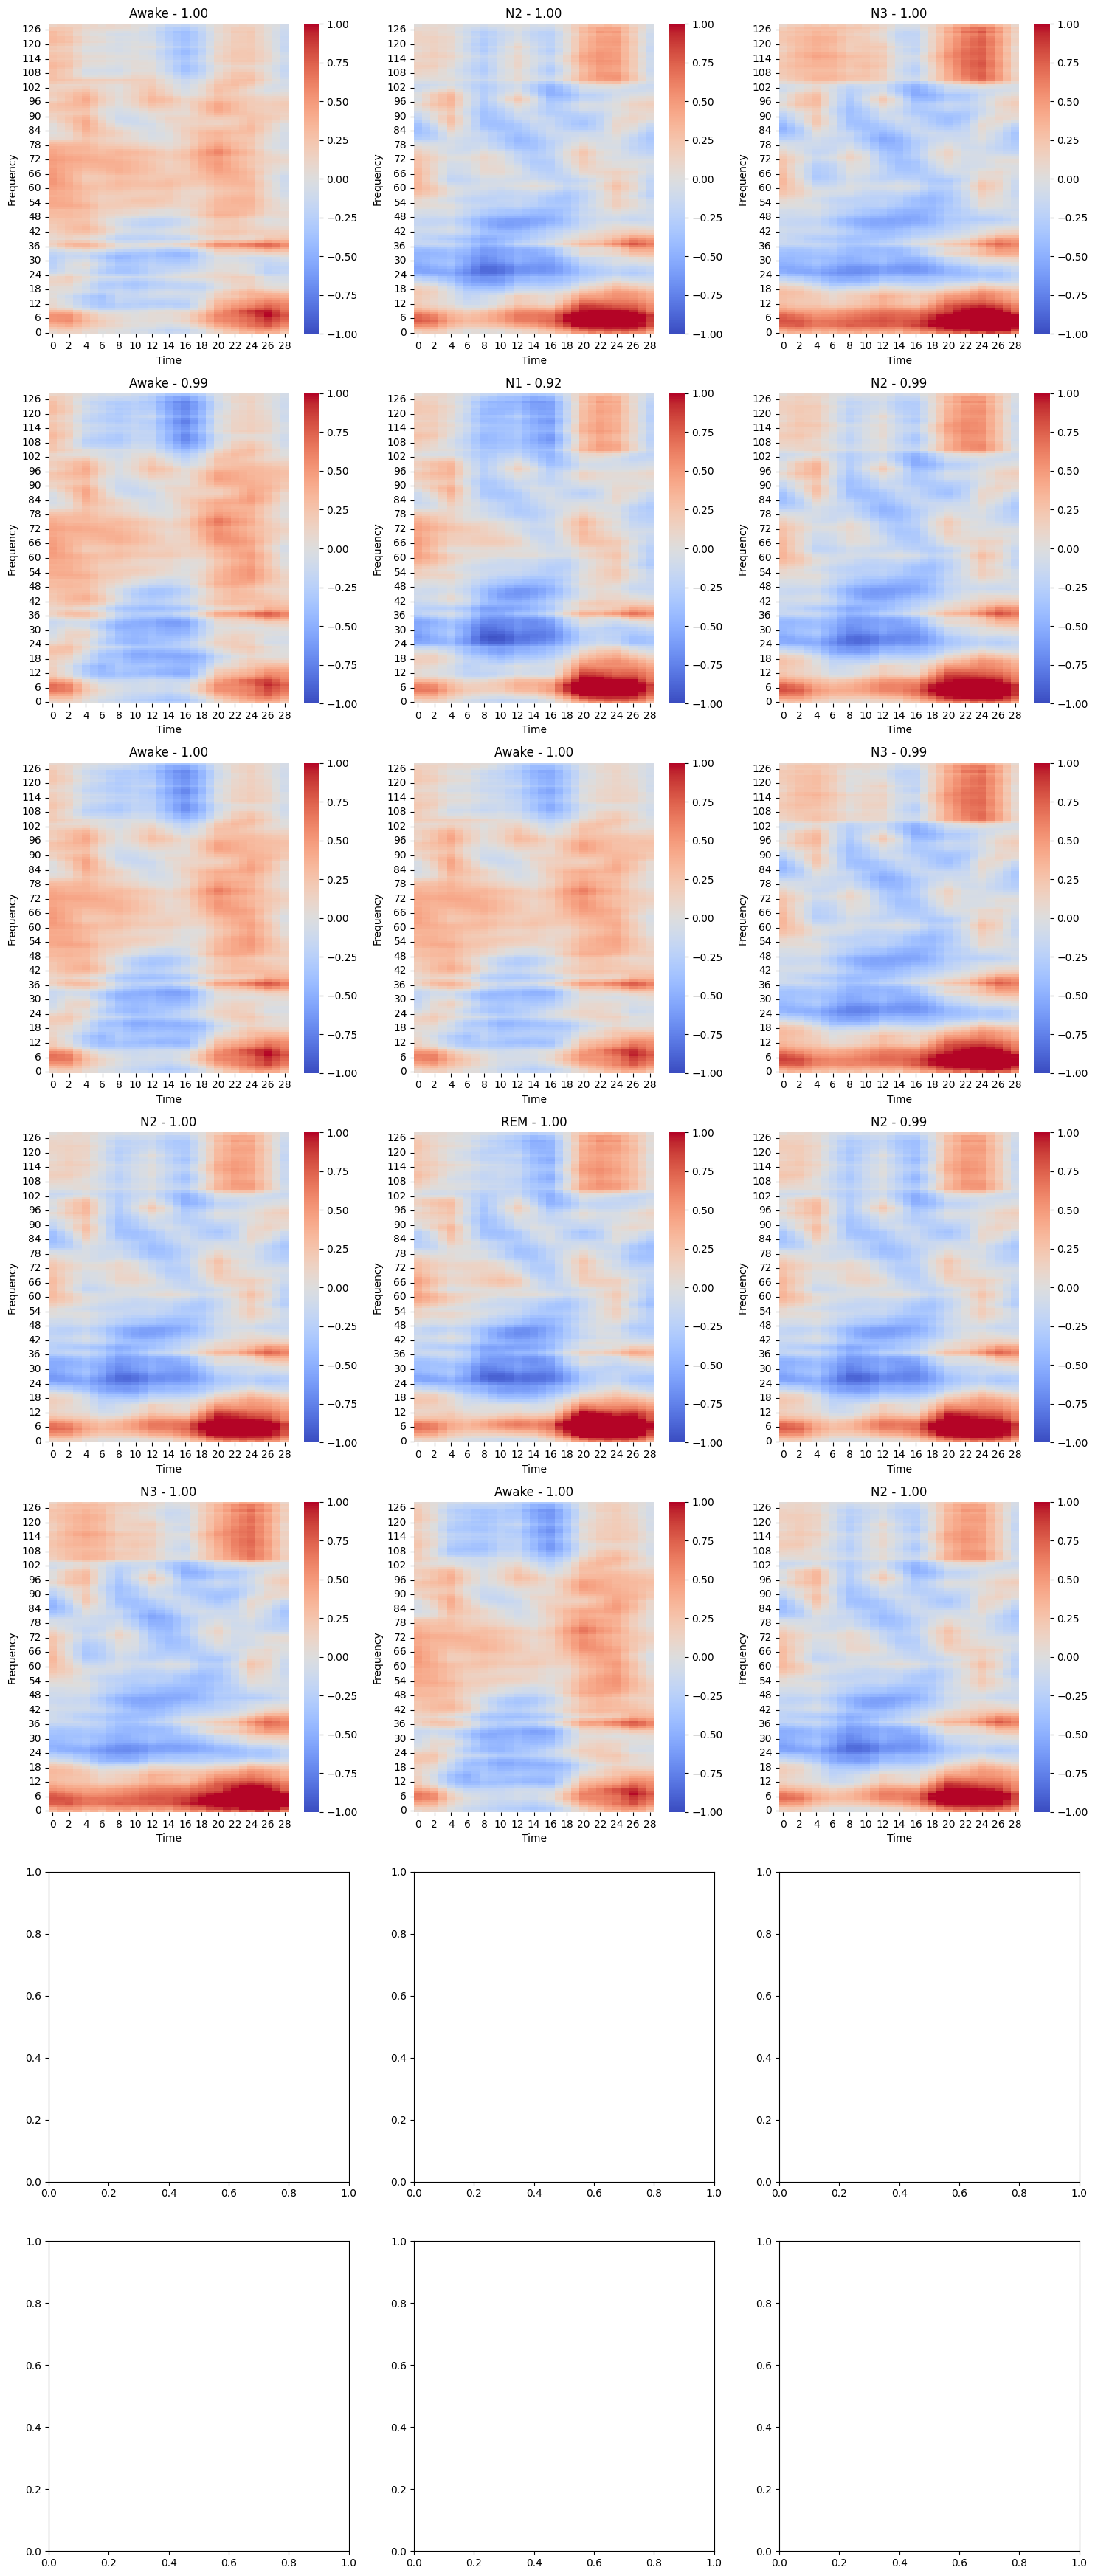

In [48]:
plotSpectrograms20(proto_rec, proto_class_list, 1, -1)

In [49]:
dataset.dataset.scaling

[(tensor([[[  1.5331,  22.4262,  25.0949,  ..., -84.9617, -82.0389, -93.7977],
           [  1.5527,  22.4885,  25.1039,  ..., -84.9423, -82.0214, -93.8318],
           [  1.5538,  22.4886,  25.1576,  ..., -85.0118, -82.0864, -93.8495],
           ...,
           [  1.4304,  22.4140,  25.0933,  ..., -85.0159, -82.0939, -93.8948],
           [  1.5213,  22.4208,  25.0593,  ..., -85.0315, -82.0604, -93.8304],
           [  1.4761,  22.4177,  25.0865,  ..., -85.0319, -82.0828, -93.8704]]]),
  tensor([[[23.4653, 17.4245, 17.7143,  ..., 17.2278, 14.8395, 21.4710],
           [23.4676, 17.3507, 17.6701,  ..., 17.1793, 14.7946, 21.5735],
           [23.4160, 17.4042, 17.7026,  ..., 17.1920, 14.8147, 21.4972],
           ...,
           [23.6003, 17.3829, 17.6555,  ..., 17.2681, 14.8821, 21.5754],
           [23.3697, 17.3829, 17.6703,  ..., 17.2658, 14.8362, 21.5225],
           [23.4521, 17.3708, 17.6510,  ..., 17.2587, 14.8814, 21.6215]]]))]

## Inputs selection to rapresent Prototypes 

In [11]:
# compute the metrics on the test set
sleep_stages = ["Awake", "N1", "N2", "N3", "REM"]
#dataloder = dataset.test_dataloader()
dataloder = dataset.test_dataloader()
num = len(dataloder)*batch_size
emb_dim = 32

model = model1

NameError: name 'model1' is not defined

In [14]:
prototypes = model.nn.classifier.prototypes.cpu().detach().numpy()
L = model.nn.L
print("seq len:", L)
central_epoch = int((L - 1) / 2)
print("central_epoch", central_epoch, "\n\n")
print("proto shape", prototypes.shape)

p=4
continue_var = False
input_count = 0
closest_embeddings = {i: [0]*p for i in range(prototypes.shape[0])}
closest_distances = {i: [float('inf')]*p for i in range(prototypes.shape[0])}
print(closest_distances)

closest_corresponding_inputs = {i: [0]*p for i in range(prototypes.shape[0])}
closest_corresponding_labels = {i: [0]*p for i in range(prototypes.shape[0])}

with torch.no_grad():
    # Aggiungi tqdm per mostrare il progresso
    for i, (inputs, labels) in tqdm(enumerate(dataloder), total=len(dataloder)):
        # Ottieni gli embeddings per il batch
        embeddings = model.nn.encode(inputs.to(device)).permute(1, 0, 2)[central_epoch].cpu().detach().numpy()

        # Calcola la distanza euclidea tra prototipi ed embeddings
        for proto_index, proto in enumerate(prototypes):
            distances = np.linalg.norm(embeddings - proto, axis=1)
            # Trova i p embeddings più vicini attualmente salvati per questo prototipo

            max_distance_index = np.argmax(closest_distances[proto_index])
            max_distance = closest_distances[proto_index][max_distance_index]
            # Se troviamo una distanza minore della distanza massima salvata, aggiorniamo la lista
            for idx, distance in enumerate(distances):
                if distance < max_distance:
                    # Se l'input è già stato salvato, non aggiornare
                    for j in range(p):
                        if(distance == closest_distances[proto_index][j]):
                            input_count = input_count+1
                            print("input_count: ", input_count)
                            continue_var = True
                    if continue_var:
                        continue_var = False
                        continue

                    # Sostituisci il più lontano se la distanza è più piccola
                    closest_distances[proto_index][max_distance_index] = distance
                    closest_embeddings[proto_index][max_distance_index] = embeddings[idx]
                    closest_corresponding_inputs[proto_index][max_distance_index] = inputs[idx]
                    closest_corresponding_labels[proto_index][max_distance_index] = labels[idx]
                    # Aggiorna il massimo
                    max_distance_index = np.argmax(closest_distances[proto_index])
                    max_distance = closest_distances[proto_index][max_distance_index]
                    # Print per far vedere che entrano input identici
                    # if(proto_index == 0):
                    #     print(max_distance_index, " con ", max_distance, "| new dictances: ", closest_distances[proto_index])

        if i == len(dataloder) - 1:
            n_last_batch = inputs.size(0)
    
for key in closest_embeddings:
    closest_embeddings[key] = np.array(closest_embeddings[key])

seq len: 3
central_epoch 1 


proto shape (15, 32)
{0: [inf, inf, inf, inf], 1: [inf, inf, inf, inf], 2: [inf, inf, inf, inf], 3: [inf, inf, inf, inf], 4: [inf, inf, inf, inf], 5: [inf, inf, inf, inf], 6: [inf, inf, inf, inf], 7: [inf, inf, inf, inf], 8: [inf, inf, inf, inf], 9: [inf, inf, inf, inf], 10: [inf, inf, inf, inf], 11: [inf, inf, inf, inf], 12: [inf, inf, inf, inf], 13: [inf, inf, inf, inf], 14: [inf, inf, inf, inf]}


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f760e1a4d30>>
Traceback (most recent call last):
  File "/home/manni/miniconda3/envs/physioex/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
  0%|          | 0/12780 [00:00<?, ?it/s]

In [52]:
input_count

0

In [79]:
closest_distances

{0: [0.016383715, 0.016412951, 0.015928062],
 1: [0.0139353955, 0.014347552, 0.013992778],
 2: [0.013350223, 0.012780261, 0.013608028],
 3: [0.016186845, 0.015777068, 0.016579365],
 4: [0.027152864, 0.025038686, 0.0241417],
 5: [0.013901152, 0.015718214, 0.015664466],
 6: [0.012935943, 0.013489198, 0.013392528],
 7: [0.014599039, 0.014503285, 0.013283903],
 8: [0.015291015, 0.01591538, 0.016273366],
 9: [0.014013191, 0.015917584, 0.016987665],
 10: [0.017644364, 0.018673643, 0.016746117],
 11: [0.016555896, 0.015689213, 0.015684705],
 12: [0.0132560525, 0.01366319, 0.010338475],
 13: [0.013708647, 0.013151518, 0.01273294],
 14: [0.01589625, 0.013931122, 0.016003886]}

In [57]:
prototypes[7]

array([ 0.34901747, -0.21014194,  0.3165436 ,  0.1405621 ,  0.02665459,
        0.09067457,  0.06026369,  0.09090706, -0.0655868 ,  0.01686329,
        0.10062138,  0.04789108, -0.10223162, -0.0742187 , -0.45667738,
       -0.1048444 ,  0.04922939, -0.207564  ,  0.08415947, -0.18603754,
        0.18518122, -0.18186364,  0.04361002, -0.12977664, -0.36996415,
       -0.07409366, -0.04418828,  0.00915068,  0.19059668,  0.35594162,
        0.11914889, -0.21127921], dtype=float32)

In [58]:
closest_embeddings[7]

array([[ 0.3473138 , -0.21442476,  0.3190882 ,  0.13806902,  0.02359877,
         0.08667938,  0.05860421,  0.09198929, -0.06019208,  0.0184529 ,
         0.10319309,  0.0452439 , -0.10790969, -0.07644899, -0.45343202,
        -0.10511361,  0.05244829, -0.21340606,  0.0819933 , -0.18863139,
         0.18499517, -0.18015549,  0.04660795, -0.12654819, -0.36944756,
        -0.06918946, -0.04468634,  0.00497776,  0.19553453,  0.36009285,
         0.12257821, -0.20875946],
       [ 0.35146153, -0.20417182,  0.31189036,  0.13745427,  0.02290126,
         0.09579425,  0.05398492,  0.09493632, -0.0606932 ,  0.0150692 ,
         0.09994084,  0.04975263, -0.10795054, -0.07102029, -0.4581277 ,
        -0.10848334,  0.04662685, -0.2059714 ,  0.08022058, -0.1853565 ,
         0.18528356, -0.18344085,  0.04598672, -0.13080457, -0.37706634,
        -0.0754432 , -0.042704  ,  0.01087174,  0.19033776,  0.36174473,
         0.12243652, -0.20930375],
       [ 0.34942815, -0.20874245,  0.31614578,  0.1387

In [53]:
for idx in closest_corresponding_labels:
    print(idx, closest_corresponding_labels[idx])

0 [tensor([0, 0, 0]), tensor([4, 4, 4]), tensor([0, 0, 1]), tensor([0, 0, 1])]
1 [tensor([2, 2, 2]), tensor([2, 2, 2]), tensor([2, 2, 2]), tensor([2, 2, 2])]
2 [tensor([3, 3, 3]), tensor([3, 2, 2]), tensor([3, 3, 3]), tensor([3, 3, 3])]
3 [tensor([0, 0, 0]), tensor([0, 0, 0]), tensor([0, 0, 0]), tensor([0, 0, 0])]
4 [tensor([0, 1, 2]), tensor([4, 4, 4]), tensor([4, 4, 4]), tensor([4, 4, 4])]
5 [tensor([2, 2, 2]), tensor([3, 2, 2]), tensor([2, 2, 2]), tensor([2, 2, 3])]
6 [tensor([4, 4, 4]), tensor([0, 0, 0]), tensor([0, 0, 0]), tensor([1, 2, 2])]
7 [tensor([2, 2, 2]), tensor([0, 0, 0]), tensor([0, 0, 0]), tensor([1, 1, 2])]
8 [tensor([2, 3, 3]), tensor([3, 3, 3]), tensor([3, 3, 3]), tensor([3, 2, 3])]
9 [tensor([2, 2, 2]), tensor([2, 2, 2]), tensor([2, 2, 2]), tensor([2, 2, 2])]
10 [tensor([4, 4, 4]), tensor([4, 4, 4]), tensor([4, 4, 4]), tensor([4, 4, 4])]
11 [tensor([2, 2, 2]), tensor([2, 2, 2]), tensor([2, 2, 2]), tensor([2, 2, 2])]
12 [tensor([2, 2, 3]), tensor([3, 3, 3]), tensor([

In [54]:
closest_corresponding_inputs[0][0][central_epoch][0].shape

torch.Size([29, 129])

In [55]:
closest_corresponding_inputs[0][0][central_epoch][0].shape #[x prototipi][p sequenze][l epoche][n canali]

torch.Size([29, 129])

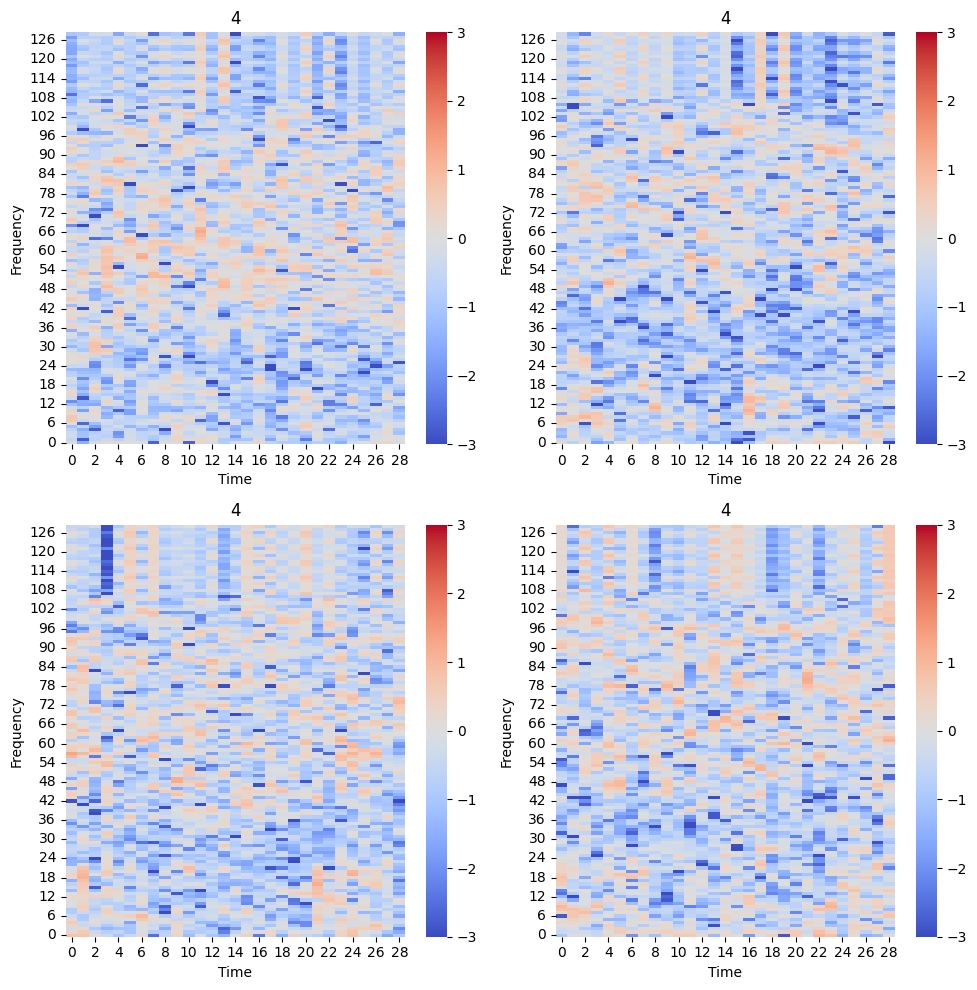

In [56]:
proto_idx_to_print = 10
labels_to_print = []
proto_to_print = []

for i in range(p):
    proto_to_print.append(closest_corresponding_inputs[proto_idx_to_print][i][central_epoch][0])
    labels_to_print.append(str(closest_corresponding_labels[proto_idx_to_print][i][central_epoch].item()))

plotSpectrograms(proto_to_print, labels_to_print, max, min)


In [58]:
np.linalg.norm(closest_corresponding_inputs[proto_idx_to_print][1] - closest_corresponding_inputs[proto_idx_to_print][2], axis=1)

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)

# SHHS DEBUG

In [12]:
dataset = PhysioExDataModule(
    datasets= ["shhs"],
    versions = None,
    folds = -1,
    batch_size=batch_size,
    preprocessing=model["input_transform"],
    selected_channels=picks,
    sequence_length = 3,
    target_transform=model["target_transform"],
    data_folder = "/home/guidogl/physioex-data/"
)

['shhs'] None
/home/guidogl/physioex-data/


In [13]:
input_to_check = torch.load("input_to_check.pt")
label_to_check = torch.load("label_to_check.pt")

In [14]:
#con xsleepnet
dataloder = dataset.test_dataloader()
counter = -1
for i, (inputs, labels) in tqdm(enumerate(dataloder), total=len(dataloder)):
    if i == 0:
        input_to_check = inputs[0]
        label_to_check = labels[0]
        print(label_to_check)
        print(input_to_check.size())
    
    for idx, label in enumerate(labels):
        if torch.equal(label, label_to_check):
            if torch.equal(inputs[idx], input_to_check):
                counter = counter + 1
                print("counter: ", counter)
print(counter)

  0%|          | 1/12780 [03:23<721:31:52, 203.26s/it]

tensor([0, 0, 0])
torch.Size([3, 1, 29, 129])
counter:  0


  0%|          | 8/12780 [04:59<132:48:16, 37.43s/it] 


KeyboardInterrupt: 

In [23]:
torch.save(label_to_check, 'label_to_check.pt')
torch.save(input_to_check, 'input_to_check.pt')

In [36]:
dataloder = dataset.val_dataloader()
counter = 0
for i, (inputs, labels) in tqdm(enumerate(dataloder), total=len(dataloder)):
    for idx, label in enumerate(labels):
        if torch.equal(label, label_to_check):
            if torch.equal(inputs[idx], input_to_check):
                counter = counter + 1
                print("counter: ", counter)
print(counter)

100%|██████████| 754/754 [06:33<00:00,  1.92it/s]

0


In [15]:
dataloder = dataset.train_dataloader()
counter = 0
for i, (inputs, labels) in tqdm(enumerate(dataloder), total=len(dataloder)):
    for idx, label in enumerate(labels):
        if torch.equal(label, label_to_check):
            if torch.equal(inputs[idx], input_to_check):
                counter = counter + 1
                print("counter: ", counter)
print(counter)

  0%|          | 8/28987 [08:57<541:02:26, 67.21s/it]  


KeyboardInterrupt: 

In [ ]:
# MASS

In [13]:
dataset = PhysioExDataModule(
    datasets= ["mass"],
    versions = None,
    folds = -1,
    batch_size=batch_size,
    preprocessing=model["input_transform"],
    selected_channels=picks,
    sequence_length = sequence_length,
    target_transform=model["target_transform"],
    data_folder = "/home/guidogl/physioex-data/"
)

['mass'] None
/home/guidogl/physioex-data/


In [17]:
dataloder = dataset.test_dataloader()
counter = -1
for i, (inputs, labels) in tqdm(enumerate(dataloder), total=len(dataloder)):
    if i == 0:
        input_to_check = inputs[0]
        label_to_check = labels[0]
        print(label_to_check)
    
    for idx, label in enumerate(labels):
        if torch.equal(label, label_to_check):
            if torch.equal(inputs[idx], input_to_check):
                counter = counter + 1
                print("counter: ", counter)
print(counter)

  6%|▋         | 6/95 [00:05<00:57,  1.56it/s]

tensor([2, 2, 2])
counter:  0


100%|██████████| 95/95 [01:04<00:00,  1.48it/s]

0


In [18]:
dataloder = dataset.val_dataloader()
counter = 0
for i, (inputs, labels) in tqdm(enumerate(dataloder), total=len(dataloder)):
    for idx, label in enumerate(labels):
        if torch.equal(label, label_to_check):
            if torch.equal(inputs[idx], input_to_check):
                counter = counter + 1
                print("counter: ", counter)
print(counter)

 48%|████▊     | 43/89 [00:34<00:31,  1.47it/s]

counter:  1


 57%|█████▋    | 51/89 [00:39<00:26,  1.44it/s]

counter:  2


100%|██████████| 89/89 [01:01<00:00,  1.45it/s]

2


In [19]:
dataloder = dataset.train_dataloader()
counter = 0
for i, (inputs, labels) in tqdm(enumerate(dataloder), total=len(dataloder)):
    for idx, label in enumerate(labels):
        if torch.equal(label, label_to_check):
            if torch.equal(inputs[idx], input_to_check):
                counter = counter + 1
                print("counter: ", counter)
print(counter)

 45%|████▌     | 727/1603 [08:38<07:45,  1.88it/s]

counter:  1


100%|██████████| 1603/1603 [18:46<00:00,  1.42it/s]

1


## Visualize Embeddings

In [59]:
embeddings_array = np.empty((num, emb_dim))
labels_array = np.empty((num))


epoch_to_save = int((model.nn.L-1)/2)
print("epoch selected: ",epoch_to_save)
print(embeddings_array.shape)
print(labels_array.shape)

prototypes = model.nn.classifier.prototypes.cpu().detach().numpy()
prototypes.shape
count = 0
correct = 0
with torch.no_grad():
    # Aggiungi tqdm per mostrare il progresso
    for i, (inputs, labels) in tqdm(enumerate(dataloder), total=len(dataloder)):
        #print(sleep_stages[labels[batch].item()])

        embedding = model.nn.encode(inputs.to(device)).permute(1, 0, 2)
        embeddings_array[i*batch_size : i*batch_size+inputs.size(0)] = embedding[epoch_to_save].cpu().numpy()
        labels_array[i*batch_size : i*batch_size+inputs.size(0)] = labels[:, epoch_to_save].cpu().numpy()

        # pred = model.nn.classify(model.nn.encode(inputs.to(device))).argmax(dim=1)
        # count = count + torch.sum(pred == 1)
        # correct += (pred == labels[:, epoch_to_save]).sum().item()

        if i == len(dataloder)-1:
            n_last_batch = inputs.size(0)

        if(i == 1200):
            break

print(count)
print(correct)

epoch selected:  1
(12160, 32)
(12160,)


100%|██████████| 95/95 [04:58<00:00,  3.14s/it] 

0
0


In [30]:
len(embeddings_array)

1635840

In [172]:
embeddings_array[len(embeddings_array)-batch_size+n_last_batch - 1]

array([-0.05291836, -0.5472613 ,  0.10784393, -0.10401716,  0.10758211,
        1.47680199, -0.48233247,  0.59534073, -1.60136509, -1.37883723,
       -0.65882695, -0.48152921,  0.29816148,  0.11829102, -0.9518497 ,
       -0.03759363,  0.24105594,  1.11390293, -0.13602398,  0.09642337,
        1.05598712,  0.10806517,  0.32025942,  1.24187648,  1.5583452 ,
        0.22696634, -1.223562  ,  0.04367378,  0.74608749,  0.02527219,
        0.04303642, -0.66277879])

In [173]:
embeddings_array[len(embeddings_array)-batch_size+n_last_batch]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan])

In [174]:
first_empty_element = len(embeddings_array)-batch_size+n_last_batch

In [175]:
embeddings_array_ref = embeddings_array[0:first_empty_element] #edf dreem
#embeddings_array_ref = embeddings_array[0:1676032] #edf dreem mass shhs
labels_array_ref = labels_array[0:first_empty_element] # edf dreem
#labels_array_ref = labels_array[0:1676032] # edf dreem mass shhs

In [33]:
#per shhs
embeddings_array_ref= embeddings_array[0:1200*128]
labels_array_ref = labels_array[0:1200*128]

In [34]:
print("Awake:\t",np.sum(labels_array_ref == 0)/len(labels_array_ref)*100)
print("N1:\t", np.sum(labels_array_ref == 1)/len(labels_array_ref)*100)
print("N2:\t",np.sum(labels_array_ref == 2)/len(labels_array_ref)*100)
print("N3:\t",np.sum(labels_array_ref == 3)/len(labels_array_ref)*100)
print("REM:\t",np.sum(labels_array_ref == 4)/len(labels_array_ref)*100)

Awake:	 27.5703125
N1:	 3.2486979166666665
N2:	 40.880859375
N3:	 13.879557291666666
REM:	 14.420572916666666


In [35]:
#np.save('000002_embeddings.npy', embeddings_array_ref)
#np.save('000002_labels.npy', labels_array_ref)

In [36]:
#embeddings_array_ref = np.load('models/vae_seqsleepnet_seq3_variare_beta/0_embeddings.npy')
#labels_array_ref = np.load('models/vae_seqsleepnet_seq3_variare_beta/0_labels.npy')

In [37]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px
from pandas.plotting import parallel_coordinates
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import DBSCAN
import seaborn as sns
from sklearn.datasets import make_blobs
import pandas as pd

palette = sns.color_palette(["#808080","#FF0000","#FFA500","#00FF00", "#0000FF"])
palette = sns.color_palette(["#808080","#FF0000","#FFA500","#00FF00", "#0000FF"])

from matplotlib.colors import LinearSegmentedColormap
colori_personalizzati =["#808080","#FF0000","#FFA500","#00FF00", "#0000FF"]
# Creazione della colormap
colormap_personalizzata = LinearSegmentedColormap.from_list('nome_colormap', colori_personalizzati, N=5)

def plot_pca_2d(data, colors, percentage=1, additional_points=None):
    # Perform PCA to reduce to 2 components
    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(data)
    # Print the explained variance
    explained_variance = pca.explained_variance_ratio_
    print(f"Explained variance by component 1: {explained_variance[0]:.2f}")
    print(f"Explained variance by component 2: {explained_variance[1]:.2f}")
    
    # Sample a percentage of the data
    if (percentage<1):
        num_elements = int(len(data) * percentage)
        random_indices = np.random.choice(len(data), num_elements, replace=False)

        # Create new sampled arrays
        pca_result = pca_result[random_indices]
        colors = colors[random_indices]
    
    plt.figure(figsize=(10, 8))
    # Define a palette with 5 distinct colors
    scatter = sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=colors, palette=palette, alpha=0.6)
    #protopyes
    if additional_points is not None:
        additional_points_scaled = scaler.transform(additional_points)
        additional_points_2d = pca.transform(additional_points_scaled)
        df_additional = pd.DataFrame(additional_points_2d, columns=['PC1', 'PC2'])
        df_additional['Cluster'] = 'Prototype'
        sns.scatterplot(data=df_additional, x='PC1', y='PC2', color='black', s=100, marker='X', edgecolor='white', legend='full',)
    plt.title('2D PCA of 32-dimensional data')
    plt.xlabel(f'Principal Component 1 ({explained_variance[0]:.2f} variance)')
    plt.ylabel(f'Principal Component 2 ({explained_variance[1]:.2f} variance)')
    plt.legend(title='Color')
    plt.grid(True)
    plt.show()

def plot_pca_3d(data, colors, percentage=1):
    # Perform PCA to reduce to 3 components
    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    pca = PCA(n_components=3)
    pca_result = pca.fit_transform(data)
    
    # Print the explained variance
    explained_variance = pca.explained_variance_ratio_
    print(f"Explained variance by component 1: {explained_variance[0]:.2f}")
    print(f"Explained variance by component 2: {explained_variance[1]:.2f}")
    print(f"Explained variance by component 3: {explained_variance[2]:.2f}")
    
    # Sample a percentage of the data
    if (percentage<1):
        num_elements = int(len(data) * percentage)
        random_indices = np.random.choice(len(data), num_elements, replace=False)

        # Create new sampled arrays
        pca_result = pca_result[random_indices]
        colors = colors[random_indices]

    # Plotting the results in 3D with color
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], c=colors, cmap=colormap_personalizzata, alpha=0.8)
    #ax.set_title('3D PCA')
    ax.set_xlabel(f'PC 1 ({explained_variance[0]:.2f} variance)')
    ax.set_ylabel(f'PC 2 ({explained_variance[1]:.2f} variance)')
    ax.set_zlabel(f'PC 3 ({explained_variance[2]:.2f} variance)')
    #plt.colorbar(scatter, ax=ax, label='Color')
    plt.show()

def plot_pca_3d_i(data, colors, percentage=1):
    # Perform PCA to reduce to 3 components
    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    pca = PCA(n_components=3)
    pca_result = pca.fit_transform(data)
    
    # Print the explained variance
    explained_variance = pca.explained_variance_ratio_
    print(f"Explained variance by component 1: {explained_variance[0]:.2f}")
    print(f"Explained variance by component 2: {explained_variance[1]:.2f}")
    print(f"Explained variance by component 3: {explained_variance[2]:.2f}")
    
    # Sample a percentage of the data
    if (percentage<1):
        num_elements = int(len(data) * percentage)
        random_indices = np.random.choice(len(data), num_elements, replace=False)

        # Create new sampled arrays
        pca_result = pca_result[random_indices]
        colors = colors[random_indices]

    # Create a DataFrame for Plotl
    df = pd.DataFrame({
        'PC1': pca_result[:, 0],
        'PC2': pca_result[:, 1],
        'PC3': pca_result[:, 2],
        'Color': colors
    })
    # Plotting the results in 3D with color
    fig = px.scatter_3d(df, x='PC1', y='PC2', z='PC3', color='Color',
                        title='3D PCA of 32-dimensional data',
                        labels={'PC1': f'PC 1 ({explained_variance[0]:.2f} variance)',
                                'PC2': f'PC 2 ({explained_variance[1]:.2f} variance)',
                                'PC3': f'PC 3 ({explained_variance[2]:.2f} variance)'},
                        color_continuous_scale='Viridis')
    fig.update_layout(width=800,height=1000,)
    fig.update_traces(marker=dict(colorscale='Viridis'))
    fig.show()

def plot_tnse_2d(data, colors, percentage=1):
    # Applicare TSNE
    tsne = TSNE(n_components=2, random_state=0)
    tsne_results_save = tsne.fit_transform(data)
    
    # Sample a percentage of the data
    if (percentage<1):
        num_elements = int(len(data) * percentage)
        random_indices = np.random.choice(len(data), num_elements, replace=False)

        # Create new sampled arrays
        tsne_results = tsne_results_save[random_indices]
        colors = colors[random_indices]

    

    # Visualizzare i risultati
    plt.figure(figsize=(10, 8))
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=colors, cmap="viridis", marker='o')
    plt.colorbar(ticks=range(5))
    plt.clim(-0.5, 2.5)
    plt.xlabel('TSNE component 1')
    plt.ylabel('TSNE component 2')
    plt.title('t-SNE visualization of Iris dataset')
    plt.show()

def plot_parcord(data, colors, percentage=1, eps = 0.00001):
    
    if (percentage<1):
            num_elements = int(len(data) * percentage)
            random_indices = np.random.choice(len(data), num_elements, replace=False)

            # Create new sampled arrays
            data = embeddings_array_ref[random_indices]
            colors = colors[random_indices]

    df = pd.DataFrame(data[:,:])
    df['phase'] = colors
    df.iloc[0, 32] = 0
    df.iloc[1, 32] = 1
    df.iloc[2, 32] = 2
    df.iloc[3, 32] = 3
    df.iloc[4, 32] = 4
    # Creare il Parallel Coordinates Plot
    for i in range(32):
        if (abs(df[i].max()) < eps) and (abs(df[i].min()) < eps):
            print("Non used feature: ", i)
            
    plt.figure(figsize=(10, 6))
    parallel_coordinates(df, 'phase', colormap=colormap_personalizzata)
    #parallel_coordinates(df, df[0])
    plt.title('Parallel Coordinates')
    plt.xlabel('Features')
    plt.ylabel('Value')
    plt.show()

def plot_silhouette_scores(data, n_clusters_range):
    silhouette_avgs = []
    scaler = StandardScaler()
    data = scaler.fit_transform(data)

    for n_clusters in n_clusters_range:
        # Eseguire il clustering con K-means
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(data)
        
        # Calcolare l'indice di silhouette medio
        if len(set(cluster_labels)) > 1:  # Assicurati che ci siano almeno due cluster
            silhouette_avg = silhouette_score(data, cluster_labels)
        else:
            silhouette_avg = -1  # Se c'è solo un cluster, silhouette score non è definito
        
        silhouette_avgs.append(silhouette_avg)
        print(f"Silhouette n={n_clusters} - {round(silhouette_avg, 3)}\\\\")

    # Creare il grafico
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=n_clusters_range, y=silhouette_avgs, marker='o')
    plt.title('Average Silhouette Score for Different Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Average Silhouette Score')
    plt.grid(True)
    plt.show()
    
def plot_KMeans_with_PCA(data, n_clusters, additional_points=None):
    # Eseguire il clustering con K-means
    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(data)
    
    # Ridurre la dimensionalità a 2D per la visualizzazione usando PCA
    pca_comp = 2
    pca = PCA(n_components=pca_comp)
    data_2d = pca.fit_transform(data)
    explained_variance = pca.explained_variance_ratio_
    for i in range(pca_comp):
        print(f"Explained variance by component {i+1}: {explained_variance[i]:.2f}")   
    
    # Creare un DataFrame per Seaborn
    df = pd.DataFrame(data_2d, columns=['PC1', 'PC2'])
    df['Cluster'] = cluster_labels

    # Plot dei cluster usando Seaborn
    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=df, x='PC1', y='PC2', hue='Cluster', palette='tab20', s=50, marker='o', legend='full')
    #protopyes
    if additional_points is not None:
        additional_points_scaled = scaler.transform(additional_points)
        additional_points_2d = pca.transform(additional_points_scaled)
        df_additional = pd.DataFrame(additional_points_2d, columns=['PC1', 'PC2'])
        df_additional['Cluster'] = 'Prototype'
        sns.scatterplot(data=df_additional, x='PC1', y='PC2', color='black', s=100, marker='X', edgecolor='white', legend='full',)

    plt.title(f'Cluster K-means (n_clusters = {n_clusters}) - PCA Projection')
    plt.xlabel(f'PC 1 ({explained_variance[0]:.2f} explained variance)')
    plt.ylabel(f'PC 2 ({explained_variance[1]:.2f} explained variance)')
    plt.legend(title='Cluster Label')
    plt.show()

def plot_KMeans_with_tSNE(data, n_clusters):
    # Eseguire il clustering con K-means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(data)

    # Ridurre la dimensionalità a 2D per la visualizzazione usando t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    data_2d = tsne.fit_transform(data)
    
    # Creare un DataFrame per Seaborn
    df = pd.DataFrame(data_2d, columns=['Dim1', 'Dim2'])
    df['Cluster'] = cluster_labels

    # Plot dei cluster usando Seaborn
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=df, x='Dim1', y='Dim2', hue='Cluster', palette='tab10', s=50, marker='o', legend='full')
    plt.title(f'Cluster K-means (n_clusters = {n_clusters}) - t-SNE Projection')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.legend(title='Cluster Label')
    plt.show()



In [38]:
df = pd.DataFrame(embeddings_array_ref)

Explained variance by component 1: 0.59
Explained variance by component 2: 0.31


/home/manni/miniconda3/envs/physioex/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


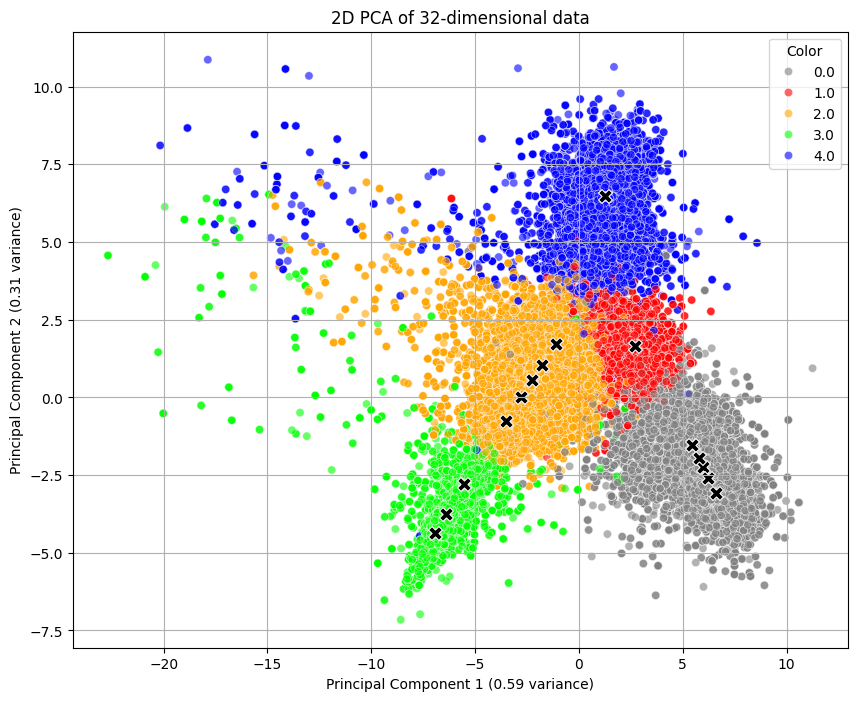

In [39]:
plot_pca_2d(embeddings_array_ref, labels_array_ref, percentage=1, additional_points=prototypes)

Explained variance by component 1: 0.59
Explained variance by component 2: 0.31
Explained variance by component 3: 0.04


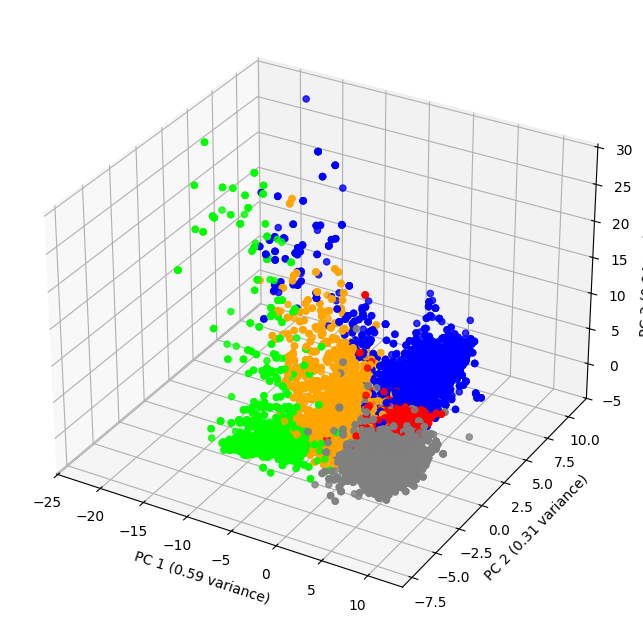

In [41]:
plot_pca_3d(embeddings_array_ref, labels_array_ref, percentage=1)

In [44]:
plot_pca_3d_i(embeddings_array_ref, labels_array_ref, percentage=0.1)

Explained variance by component 1: 0.59
Explained variance by component 2: 0.31
Explained variance by component 3: 0.04


Explained variance by component 1: 0.59
Explained variance by component 2: 0.31


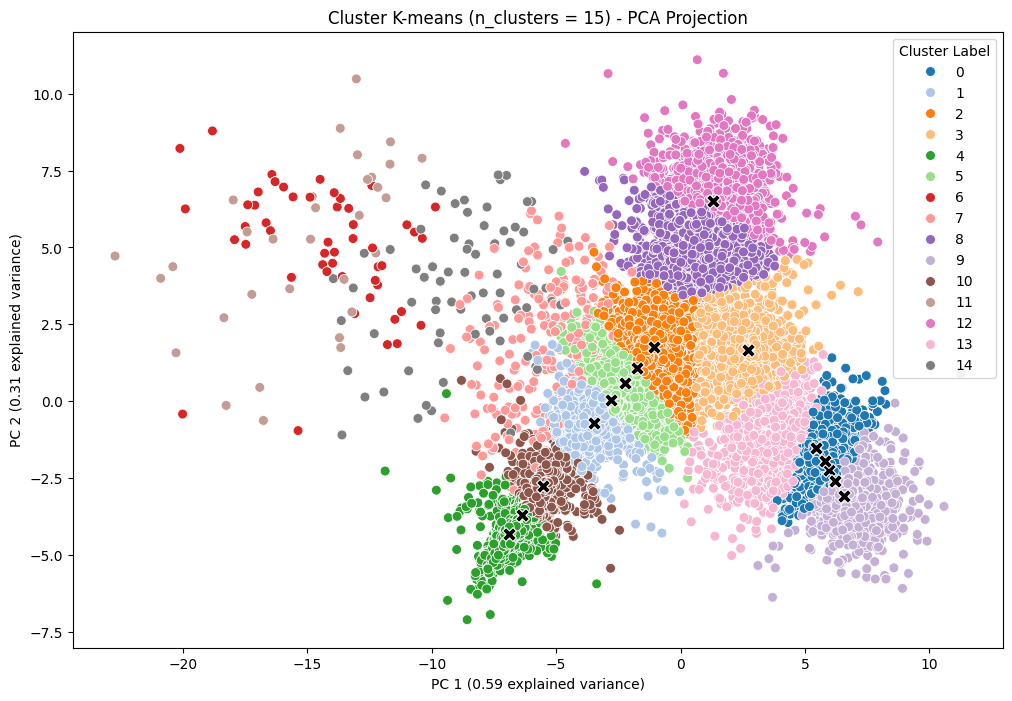

In [46]:
plot_KMeans_with_PCA(embeddings_array_ref, 15, prototypes)

In [40]:
#plot_KMeans_with_tSNE(embeddings_array_ref, 9)

In [47]:
plot_silhouette_scores(embeddings_array_ref, range(2, 20))

Silhouette n=2 - 0.474\\
Silhouette n=3 - 0.525\\


KeyboardInterrupt: 

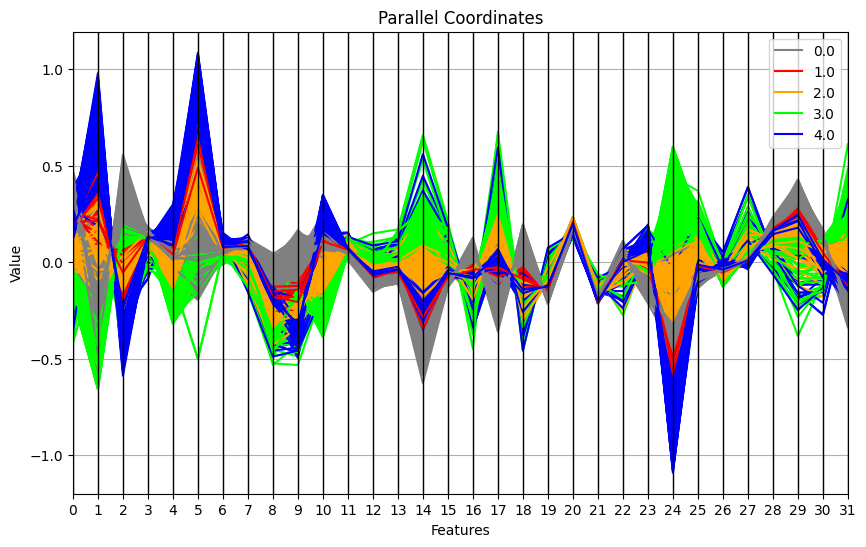

In [43]:
plot_parcord(embeddings_array_ref, labels_array_ref, percentage=0.1, eps = 0.01)

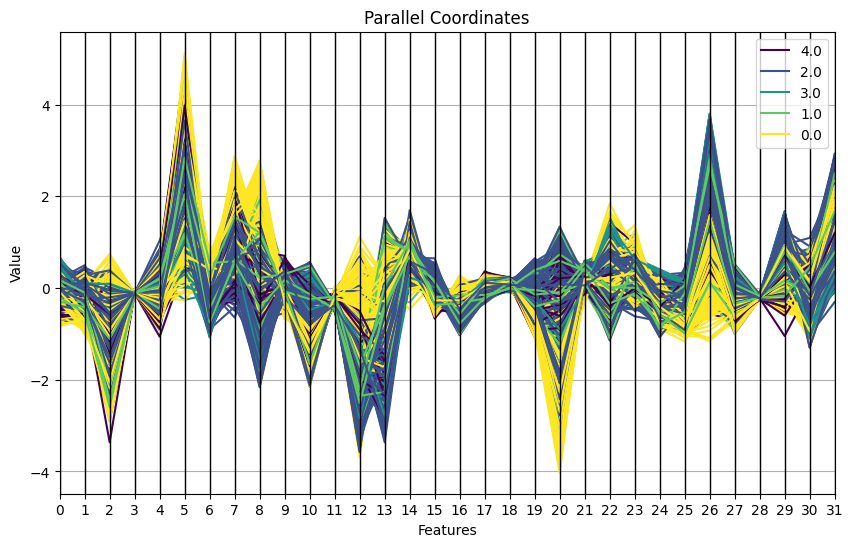

In [ ]:
from pandas.plotting import parallel_coordinates

data = embeddings_array_ref
colors = labels_array_ref
percentage = 0.05

# pca = PCA(n_components=3)
# pca_result = pca.fit_transform(data)

if (percentage<1):
        num_elements = int(len(data) * percentage)
        random_indices = np.random.choice(len(data), num_elements, replace=False)

        # Create new sampled arrays
        data = embeddings_array_ref[random_indices]
        colors = colors[random_indices]

df = pd.DataFrame(data[:,:])
df['phase'] = colors

# Creare il Parallel Coordinates Plot
plt.figure(figsize=(10, 6))
parallel_coordinates(df, 'phase', colormap='viridis')
plt.title('Parallel Coordinates')
plt.xlabel('Features')
plt.ylabel('Value')
plt.show()

## Plotting the validation loss

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_from_csv(files, label, metric='val_loss'):
    colors = ['g', 'b', 'r']  # Define colors for the plots
    rainbow_colors = [
    "#FF0000",  # Rosso
    "#FF7F00",  # Arancione
    'g', #"#00FF00",  # Verde
    #"#FFFF00",  # Giallo
    "#0000FF",  # Blu
    "#4B0082",  # Indigo
    "#8B00FF",   # Viola
        
]   
    for i, file in enumerate(files):
        # Read the CSV file
        df = pd.read_csv(file)
        df = df.dropna(subset=[metric])
        # Extract 'Epoch' and 'Val_loss' columns
        epochs = df['step']/(df['step'].max()/df['epoch'].max())
        val_loss = df[metric]
        
        # Handle missing values by interpolating
        #val_loss = val_loss.interpolate()
        
        # Plot the values
        plt.plot(epochs, val_loss, color=rainbow_colors[i], label=label[i])

    # Add labels and title
    plt.xlabel('epoch')
    plt.ylabel(metric)
    plt.legend()
    #plt.grid(True)
    plt.show()

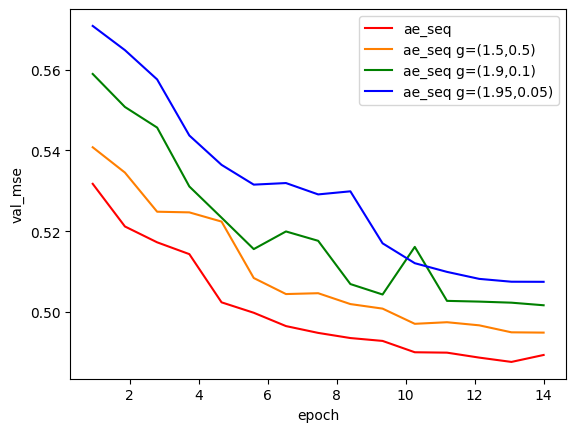

In [8]:
# List of CSV files
files = [
    'models/ae_seq3_freq_importance_da_mettere_in_tesi/ae_seq_weighted_1.0_1.0/version_0/metrics.csv',
    'models/ae_seq3_freq_importance_da_mettere_in_tesi/ae_seq_weighted_1.5_0.5/version_0/metrics.csv',
    'models/ae_seq3_freq_importance_da_mettere_in_tesi/ae_seq_weighted_1.9_0.1/version_0/metrics.csv',
    'models/ae_seq3_freq_importance_da_mettere_in_tesi/ae_seq_weighted_1.95_0.05/version_0/metrics.csv',
]
#legend = ['phi1=1.0, phi2=1.0','phi1=1.8, phi2=0.2', 'phi1=1.9, phi2=0.1']
legend  = ['ae_seq','ae_seq g=(1.5,0.5)', 'ae_seq g=(1.9,0.1)', 'ae_seq g=(1.95,0.05)']
# Call the function to plot the data
plot_from_csv(files, legend, metric='val_mse')

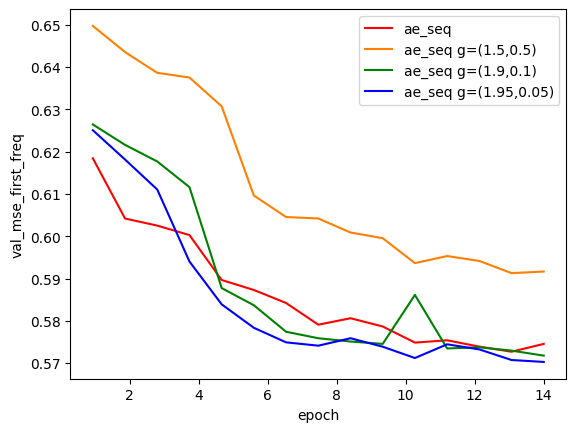

In [38]:
plot_from_csv(files, legend, metric='val_mse_first_freq')

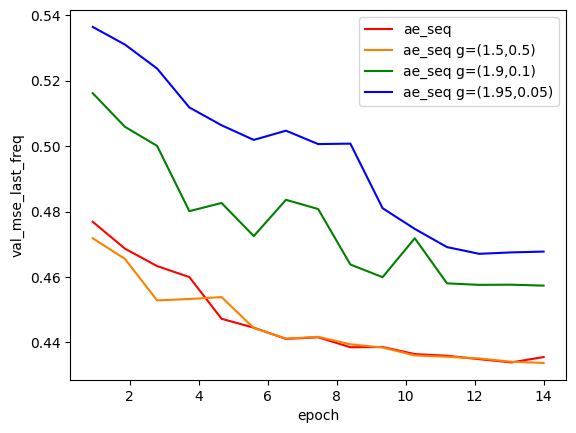

In [39]:
plot_from_csv(files, legend, metric='val_mse_last_freq')

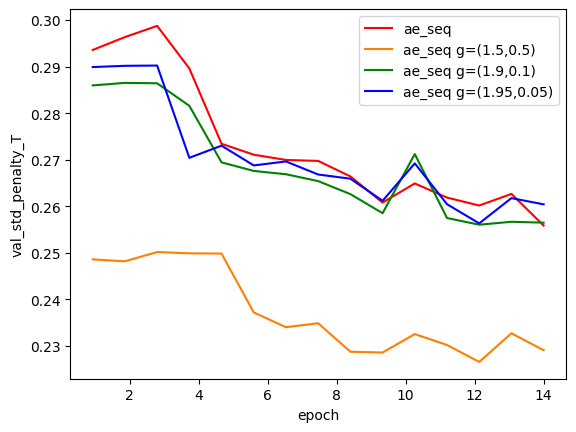

In [40]:
plot_from_csv(files, legend, metric='val_std_penalty_T')

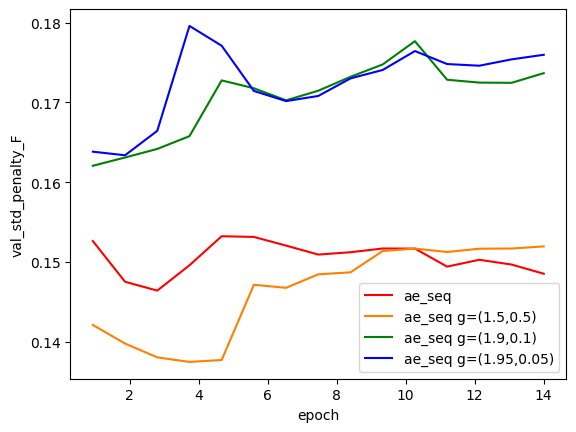

In [41]:
plot_from_csv(files, legend, metric='val_std_penalty_F')

## Proto Loss Visualization

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_model_csv(file, metrics):
    rainbow_colors = [
    "#FF0000",  # Rosso
    "#FF7F00",  # Arancione
    'g', #"#00FF00",  # Verde
    "#FFFF00",  # Giallo
    "#0000FF",  # Blu
    "#4B0082",  # Indigo
    "#8B00FF",   # Viola
    ""
    ]
    colors = [
    "r",  # Tomato (Rosso pomodoro)
    "#40E0D0",  # Turquoise (Turchese)
    "#FFD700",  # Gold (Oro)
    "#8A2BE2",  # BlueViolet (Blu violetto)
    "gray",  # OrangeRed (Arancione rosso)
    "#2E8B57",  # SeaGreen (Verde mare)
    "#DAA520",  # GoldenRod (Rododendro dorato)
    "b",  # DarkTurquoise (Turchese scuro)
    "#FF1493"   # DeepPink (Rosa intenso)
    ]   
    df = pd.read_csv(file)
    plt.figure(figsize=(10, 6))
    for i, metric in enumerate(metrics):
        df = df.dropna(subset=[metric])
        # Extract 'Epoch' and 'Val_loss' columns
        epochs = df['step']/(df['step'].max()/df['epoch'].max())
        metric_ = df[metric]
        
        # Handle missing values by interpolating
        #val_loss = val_loss.interpolate()
        
        # Plot the values
        plt.plot(epochs, metric_, color=colors[i], label=metrics[i])

    # Add labels and title
    plt.xlabel('epoch')
    #plt.ylabel('')
    plt.ylim(0, 1.2)
    plt.legend(loc='lower left')
    #plt.grid(True)
    plt.show()
    

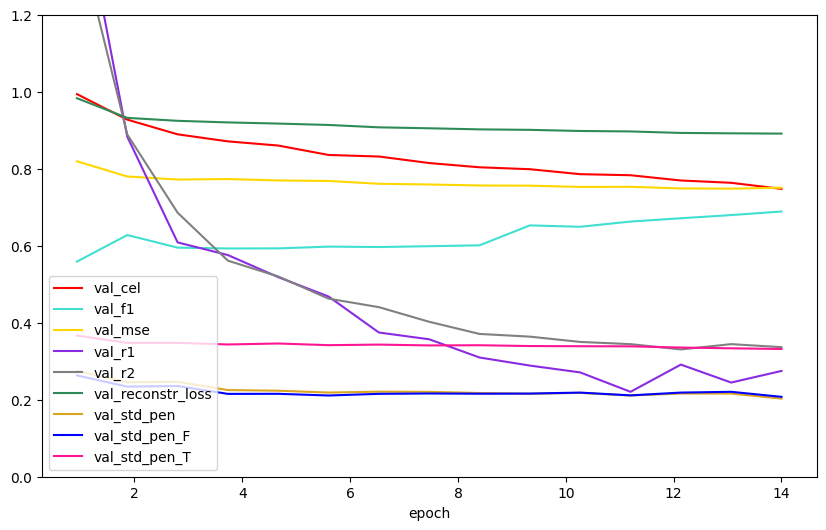

In [30]:
metrics = ['val_cel', 'val_f1', 'val_mse', 'val_r1', 'val_r2', 'val_reconstr_loss',
           'val_std_pen', 'val_std_pen_F', 'val_std_pen_T']
file = 'models/protoae_seqsleepnet/proto_mass3311/lightning_logs/version_0/metrics.csv'
plot_model_csv(file, metrics)

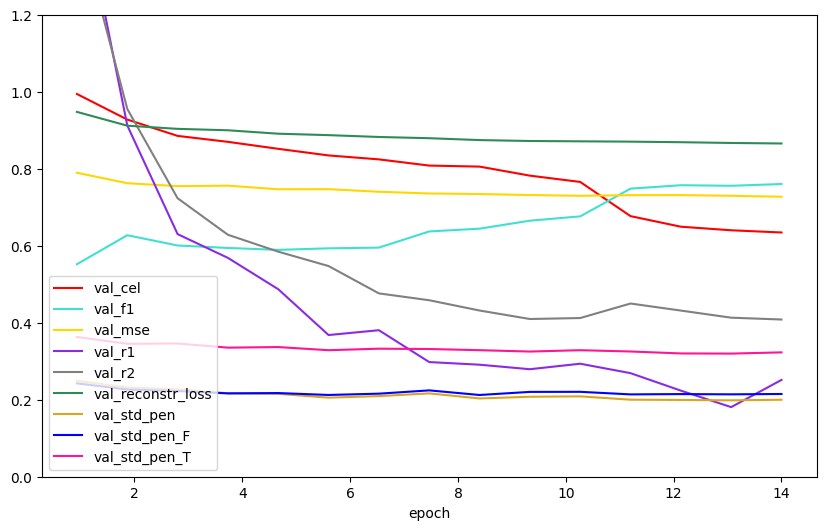

In [31]:
metrics = ['val_cel', 'val_f1', 'val_mse', 'val_r1', 'val_r2', 'val_reconstr_loss',
           'val_std_pen', 'val_std_pen_F', 'val_std_pen_T']
file = 'models/protoae_seqsleepnet/proto_mass3611/lightning_logs/version_0/metrics.csv'
plot_model_csv(file, metrics)

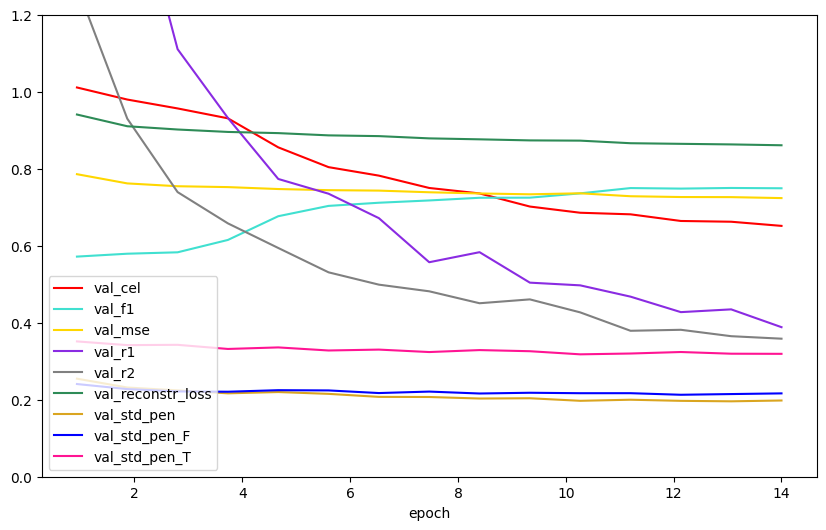

In [32]:
metrics = ['val_cel', 'val_f1', 'val_mse', 'val_r1', 'val_r2', 'val_reconstr_loss',
           'val_std_pen', 'val_std_pen_F', 'val_std_pen_T']
file = 'models/protoae_seqsleepnet/proto15_mass3611/lightning_logs/version_0/metrics.csv'
plot_model_csv(file, metrics)

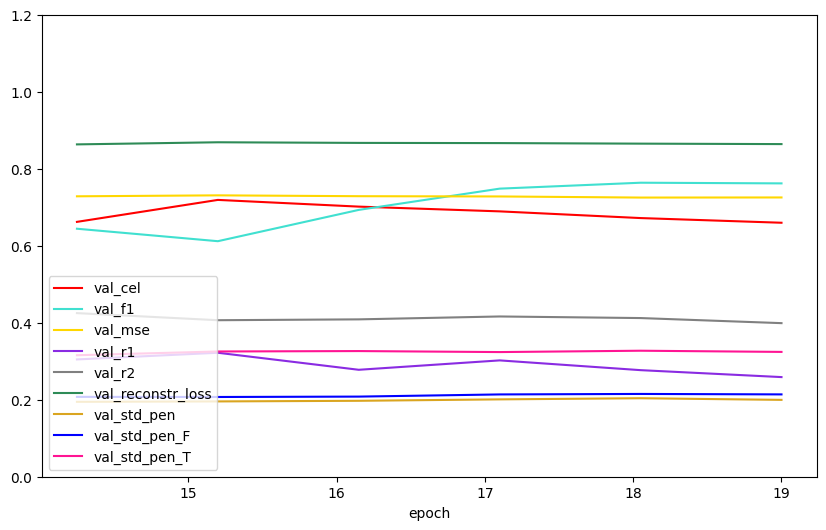

In [52]:
metrics = ['val_cel', 'val_f1', 'val_mse', 'val_r1', 'val_r2', 'val_reconstr_loss',
           'val_std_pen', 'val_std_pen_F', 'val_std_pen_T']
file = 'models/protoae_seqsleepnet/proto20_mass3611_20epoch/lightning_logs/version_0/metrics.csv'
plot_model_csv(file, metrics)